<a href="https://colab.research.google.com/github/rybread1/lego-minifigure-classification/blob/master/lego_image_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install albumentations --upgrade

     |████████████████████████████████| 122kB 7.1MB/s 
     |████████████████████████████████| 952kB 21.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=e95500fa7f3bb0bc5f1cb35135d504fb6f9076fd9268b5473628355a6f01f99a
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import math
import seaborn as sn
import albumentations as A
import tensorflow as tf
from sklearn import metrics as sk_metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Importing Dataset**

*   download the lego-classification dataset here: https://www.kaggle.com/ihelon/lego-minifigures-classification. 




In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
lego_dir = '/content/gdrive/My Drive/lego-data'
index = pd.read_csv(os.path.join(lego_dir, 'index.csv')).drop('Unnamed: 0', axis=1)
meta_data = pd.read_csv(os.path.join(lego_dir, 'metadata.csv')).drop('Unnamed: 0', axis=1)

df = index.merge(meta_data, on='class_id')

# **Data Exploration**

In [5]:
df.head()

,path,class_id,train-valid,lego_ids,lego_names,minifigure_name
0,marvel/0001/001.jpg,1,train,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
1,marvel/0001/002.jpg,1,valid,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
2,marvel/0001/003.jpg,1,train,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
3,marvel/0001/004.jpg,1,train,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
4,marvel/0001/005.jpg,1,train,[76115],['Spider Mech vs. Venom'],SPIDER-MAN


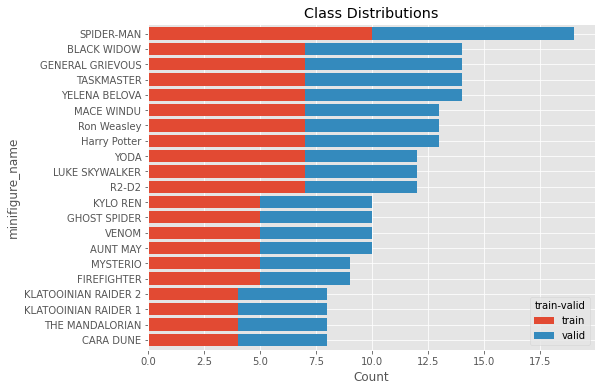

In [6]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 6))

df_counts = df.groupby('train-valid')['minifigure_name'].value_counts().unstack().T.reset_index()
df_counts['total'] = df_counts['train'] + df_counts['valid']
df_counts = df_counts.set_index('minifigure_name')
df_counts.sort_values(by='total', ascending=True)[['train', 'valid']].plot.barh(width=0.8, stacked=True, ax=ax)

plt.xlabel('Count')
plt.title('Class Distributions');

Let's look at a couple of examples

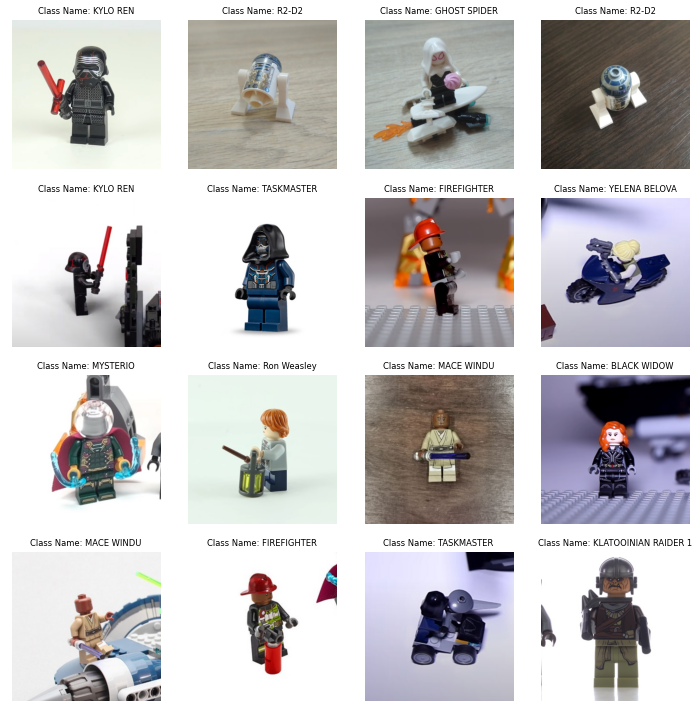

In [7]:
plt.figure(figsize=(10, 10))

for i, ex in enumerate(df.sample(16, random_state=0).iterrows(), 1):
  plt.subplot(4, 4, i)
  image = cv2.imread(os.path.join(lego_dir, ex[1]['path']))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.title(f"Class Name: {ex[1]['minifigure_name']}", size='small')

plt.tight_layout()

"You Are On This Council, But We Do Not Grant You The Rank Of Master." -  Mace Windu

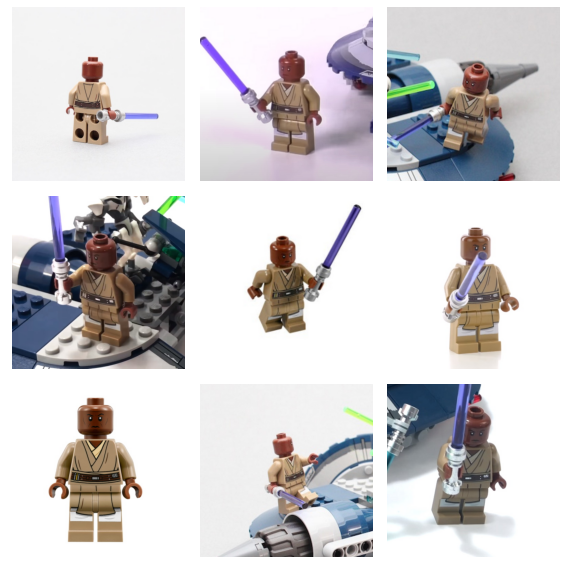

In [8]:
plt.figure(figsize=(8, 8))

cond = df['minifigure_name'] == 'MACE WINDU'
for i, ex in enumerate(df[cond].sample(9, random_state=0).iterrows(), 1):
  plt.subplot(3, 3, i)
  image = cv2.imread(os.path.join(lego_dir, ex[1]['path']))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()

# Image Augmentations

In [ ]:
img_augmenter = A.Compose(
        [
            A.augmentations.transforms.Rotate(limit=30, border_mode=cv2.BORDER_REPLICATE, p=0.5),
            A.augmentations.transforms.Cutout(num_holes=8, max_h_size=20, max_w_size=20, fill_value=0, p=0.5),
            A.augmentations.transforms.Cutout(num_holes=8, max_h_size=20, max_w_size=20, fill_value=1, p=0.5),
            A.augmentations.transforms.HorizontalFlip(p=0.5),
            A.augmentations.transforms.RandomContrast(p=0.5),
            A.augmentations.transforms.Blur(p=0.5),
        ], 
        p=1.0
    )

# Data Generator Class


---

see: https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

Wrap all the preprocessing steps into a data generator class:


*   Reads in the images using the image paths
*   Performs image preprocessing steps
*   Pass a transformer object to perform image augmentation
*   Funcationality for batch size and repeating



In [72]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self, 
        paths, 
        targets, 
        image_size=(224, 224), 
        batch_size=64, 
        shuffle=True, 
        repeats=1,
        transforms=None
    ):
        # how many times to repeat training on the dataset per epoch
        self.repeats = repeats
        # the list of paths to files
        self.paths = np.repeat(paths, self.repeats, axis=0)
        # the list with the true labels of each file
        self.targets = np.repeat(targets, self.repeats, axis=0)        
        # images size
        self.image_size = image_size
        # batch size (the number of images)
        self.batch_size = batch_size
        # if we need to shuffle order of files
        # for validation we don't need to shuffle, for training - do
        self.shuffle = shuffle
        # Augmentations for our images. It is implemented with albumentations library
        self.transforms = transforms
        
        # Call function to create and shuffle (if needed) indices of files
        self.on_epoch_end()
        
    def on_epoch_end(self):
        # This function is called at the end of each epoch while training
        
        # Create as many indices as many files we have
        self.indexes = np.arange(len(self.paths))
        # Shuffle them if needed
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        # We need that this function returns the number of steps in one epoch
        
        # How many batches we have
        return (len(self.indexes) // self.batch_size)

    
    def __getitem__(self, index):
        # Take in order as many indices as our batch size is
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        
        # Take image file paths that are included in that batch
        batch_paths = [self.paths[k] for k in indexes]
        # Take labels for each image
        batch_y = [self.targets[k] - 1 for k in indexes]
        batch_X = []


        for i in range(self.batch_size):
            # Read the image
            img = cv2.imread(batch_paths[i])
            # Resize it to needed shape
            img = cv2.resize(img, self.image_size)
            # Convert image colors from BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Normalize image
            img = img / 255.0
            # Apply transforms (see albumentations library)
            if self.transforms:
                img = self.transforms(image=img)['image']
            
            batch_X.append(img)
            
        return np.array(batch_X), np.array(batch_y)

In [75]:
train_cond = df['train-valid']=='train'
train_gen = DataGenerator(
    paths=df[train_cond]['path'].apply(lambda x: os.path.join(lego_dir, x)).values,
    targets=df[train_cond]['class_id'].values,
    image_size=(512,512),
    batch_size=4,
    repeats=3,
    shuffle=True,
    transforms=img_augmenter
)

test_cond = df['train-valid']=='valid'
test_gen = DataGenerator(
    paths=df[test_cond]['path'].apply(lambda x: os.path.join(lego_dir, x)).values,
    targets=df[test_cond]['class_id'].values,
    image_size=(512,512),
    batch_size=1,
    repeats=1,
    shuffle=False,
    transforms=None
)

# Create the model


---



*   Using pretrained MobileNetV2: https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2
*   22 output classes



In [76]:
n_classes = df['class_id'].nunique()

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2()
# Take penultimate layer of the MobileNetV2 model and connect this layer with Dropout
x = tf.keras.layers.Dropout(0.5)(base_model.layers[-2].output)
outputs = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
model = tf.keras.Model(base_model.inputs, outputs)

# Compile model using Adam optimizer and categorical crossentropy loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [77]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

callback_save = tf.keras.callbacks.ModelCheckpoint(
    'best.hdf5',
    monitor="val_loss",
    save_best_only=True,
    mode="min",
)

results = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=50,
    callbacks=[callback_save, early_stop_callback]
)

Epoch 1/50
94/94 [==============================] - 15s 163ms/step - loss: 3.0426 - accuracy: 0.1144 - val_loss: 3.0201 - val_accuracy: 0.0789
Epoch 2/50
94/94 [==============================] - 14s 154ms/step - loss: 2.2746 - accuracy: 0.3883 - val_loss: 2.4794 - val_accuracy: 0.2807
Epoch 3/50
94/94 [==============================] - 14s 154ms/step - loss: 1.5168 - accuracy: 0.6277 - val_loss: 1.8875 - val_accuracy: 0.6404
Epoch 4/50
94/94 [==============================] - 14s 153ms/step - loss: 0.8607 - accuracy: 0.8511 - val_loss: 1.2466 - val_accuracy: 0.7895
Epoch 5/50
94/94 [==============================] - 15s 155ms/step - loss: 0.5589 - accuracy: 0.9202 - val_loss: 0.7900 - val_accuracy: 0.8772
Epoch 6/50
94/94 [==============================] - 14s 152ms/step - loss: 0.3522 - accuracy: 0.9468 - val_loss: 0.5492 - val_accuracy: 0.9211
Epoch 7/50
94/94 [==============================] - 15s 154ms/step - loss: 0.2238 - accuracy: 0.9787 - val_loss: 0.4449 - val_accuracy: 0.9298

# Performance


---



Able to achieve 100% accurary on the validation dataset



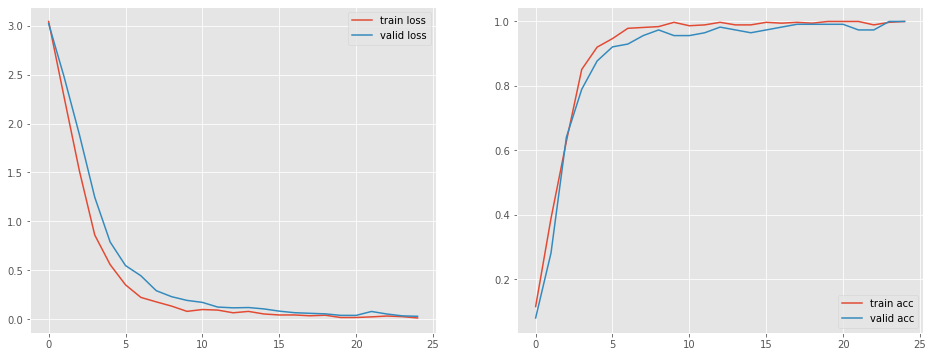

In [78]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'][:-3], label='train loss')
plt.plot(results.history['val_loss'][:-3], label='valid loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'][:-3], label='train acc')
plt.plot(results.history['val_accuracy'][:-3], label='valid acc')
plt.legend();

# Confusion Matrix

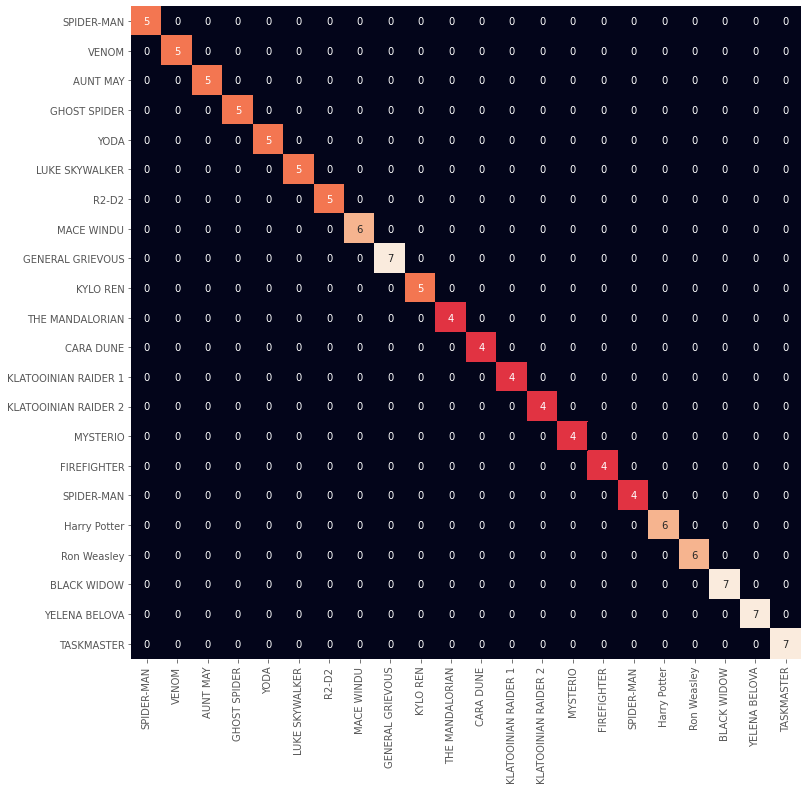

In [82]:
labels = meta_data['minifigure_name'].tolist()
confusion_matrix = sk_metrics.confusion_matrix(y_valid, y_pred)
df_confusion_matrix = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
plt.figure(figsize=(12, 12))
sn.heatmap(df_confusion_matrix, annot=True, cbar=False);

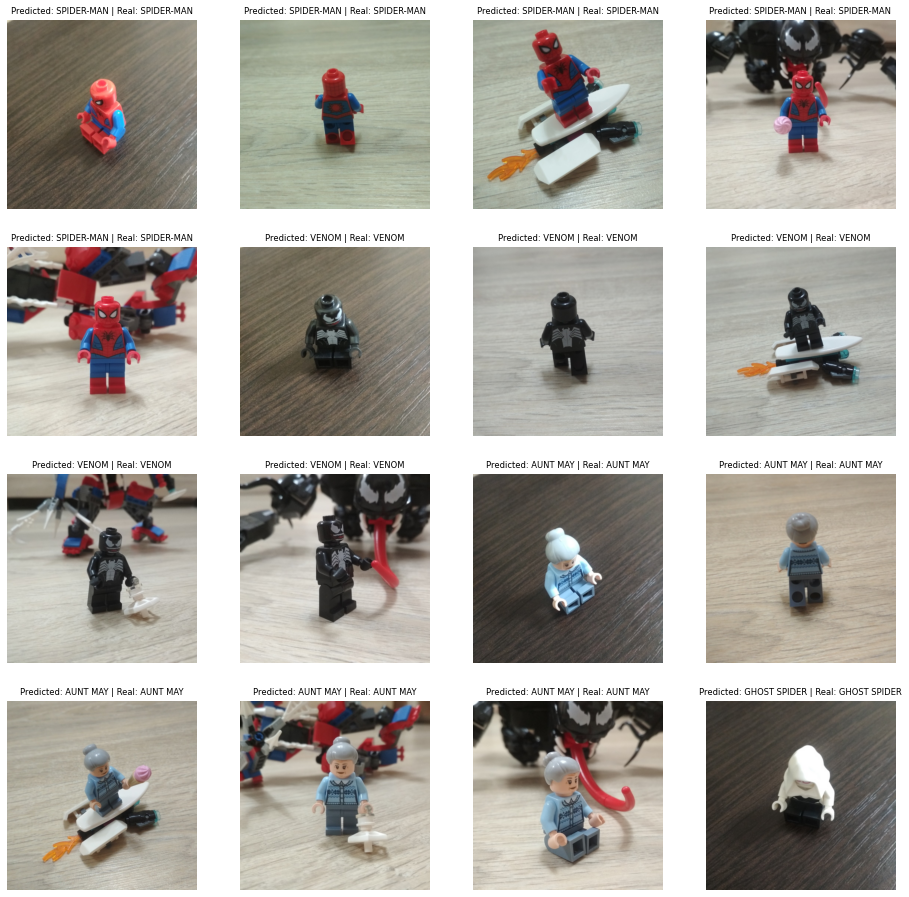

In [89]:
true_images = []
true_label = []
true_pred = []

for _X_valid, _y_valid in test_gen:
    pred = model.predict(_X_valid).argmax(axis=-1)
    if pred[0] == _y_valid:
        true_images.extend(_X_valid)
        true_label.extend(_y_valid)
        true_pred.extend(pred)

true_images = true_images[:16]

fig, ax = plt.subplots(figsize=(16, 16))

for ind, image in enumerate(true_images):
    plt.subplot(math.ceil(len(true_images) / int(len(true_images) ** 0.5)), int(len(true_images) ** 0.5), ind + 1)
    plt.imshow(image)
    plt.title(f'Predicted: {labels[true_pred[ind]]} | Real: {labels[true_label[ind]]}', size='small')
    plt.axis('off')

